# Variational Quantum Classifier (VQC)

VQC are used for classification tasks. We design a quantum circuit that can be trained from a labelled data to classify new samples.

For our first classifier, we will encode binary inputs from the computational basis state into the initial state of the circuit. This is known as basis encoding.

In the second classifier, we encode real vectors as amplitude vectors into quantum states. This is known as amplitude encoding.

## 1. Fitting the parity function

### Installing and Importing the required libraries
Import the necessary libraries for creating the QVC.

In [1]:
# %pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

### Quantum and Classical nodes

In [3]:
dev = qml.device("default.qubit")

Our layer uses four qubits with arbitrary rotations on every qubit. Then we apply CNOTs to entangle each qubit with its neighbour.

In [4]:
n_qubits = 4 # number of qubits in our circuit layer
set_nodes = ([0, 1], [1, 2], [2, 3], [3, 0]) # entangling neighbouring qubits

In [5]:
def layer(l_weights):
    for wire in range(n_qubits):
        qml.Rot(*l_weights[wire], wires=wire)
    
    for wires in set_nodes:
        qml.CNOT(wires)

In [6]:
def state_prep(x):
    qml.BasisState(x, wires=range(n_qubits))

In [7]:
@qml.qnode(dev)
def circuit(weights, x=None):
    state_prep(x)
    
    for l_weights in weights:
        layer(l_weights)
    
    return qml.expval(qml.PauliZ(0))

In [8]:
def vqc(weights, bias, x):
    return circuit(weights, x) + bias

### Cost Function

In [9]:
def sq_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2) # conversion of predictions from unstacked tensor to stacked array for subtraction from labels

In [10]:
def accuracy(labels, predictions):
    acc = sum(abs(l-p) < 1e-5 for l, p in zip(labels, predictions)) / len(labels)
    return acc

In [11]:
def cost(weights, bias, x, y):
    predictions = [vqc(weights, bias, x_) for x_ in x]
    return sq_loss(y, predictions)

### Optimization

In [12]:
data = np.loadtxt("T2_data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = 2*Y - 1  # shift label from {0, 1} to {-1, 1}

for x, y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [13]:
np.random.seed(42)
n_layers = 2
W_init = 0.01 * np.random.randn(n_layers, n_qubits, 3, requires_grad=True)
b_init = 0.0

print("Initial weights:", W_init)
print("Initial bias:", b_init)

Initial weights: [[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]
  [ 0.01579213  0.00767435 -0.00469474]
  [ 0.0054256  -0.00463418 -0.0046573 ]]

 [[ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]
  [-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]]]
Initial bias: 0.0


**Nesterov Momentum Optimizer**

$ a^{(t+1)} = m a^{(t)} + \eta \nabla f(x^{(t)} - m a^{(t)}) $.

In [14]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [15]:
W = W_init
b = b_init
for iter in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    W, b = opt.step(cost, W, b, x=X_batch, y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(vqc(W, b, x)) for x in X]

    current_cost = cost(W, b, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {iter+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.9983967 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9885366 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9729116 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.7986496 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.0352296 | Accuracy: 0.5000000
Iter:    6 | Cost: 0.9819573 | Accuracy: 0.6000000
Iter:    7 | Cost: 1.1280550 | Accuracy: 0.5000000
Iter:    8 | Cost: 1.1872524 | Accuracy: 0.5000000
Iter:    9 | Cost: 1.0425217 | Accuracy: 0.3000000
Iter:   10 | Cost: 0.9787829 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9821230 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0106347 | Accuracy: 0.5000000
Iter:   13 | Cost: 1.0834597 | Accuracy: 0.5000000
Iter:   14 | Cost: 0.6074941 | Accuracy: 1.0000000
Iter:   15 | Cost: 0.2009796 | Accuracy: 1.0000000
Iter:   16 | Cost: 0.1407904 | Accuracy: 1.0000000
Iter:   17 | Cost: 0.1519073 | Accuracy: 1.0000000
Iter:   18 | Cost: 0.0648151 | Accuracy: 1.0000000
Iter:   19 | Cost: 0.0449583 | Accuracy: 1.0000000
Iter:   20 | Cost: 0.0146364 | 

In [16]:
data = np.loadtxt("T2_data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = 2*Y_test - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(vqc(W, b, x)) for x in X_test]

for x, y, p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


Let's use another encoding strategy

## 2. Iris Classification

### Quantum and Classical Nodes

In [17]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_prep(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [18]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

@qml.qnode(dev)
def test(angles):
    state_prep(angles)
    return qml.state()

state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


### Cost Function

In [19]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = vqc(weights, bias, X.T)
    return sq_loss(Y, predictions)

In [20]:
data = np.loadtxt("T2_data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


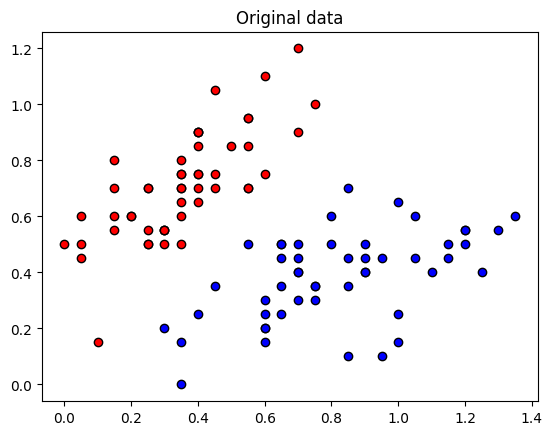

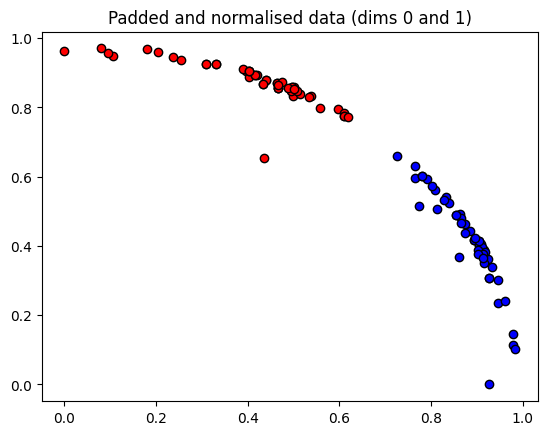

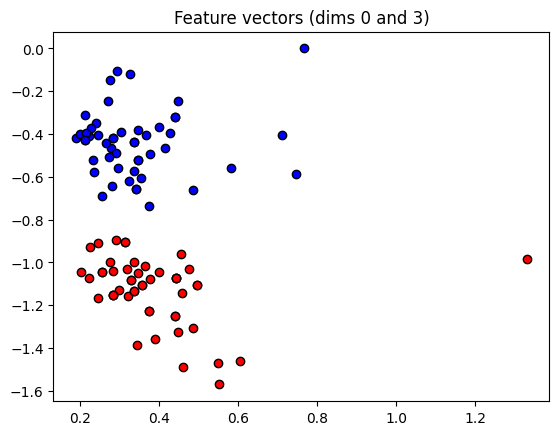

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

In [22]:
np.random.seed(42)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

### Optimization

In [23]:
num_qubits = 2
num_layers = 6

W_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
b_init = np.array(0.0, requires_grad=True)

In [26]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
W = W_init
b = b_init
for iter in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    W, b, _, _ = opt.step(cost, W, b, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(vqc(W, b, feats_train.T))
    predictions_val = np.sign(vqc(W, b, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (iter + 1) % 2 == 0:
        _cost = cost(W, b, features, Y)
        print(
            f"Iter: {iter + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.7215939 | Acc train: 0.4533333 | Acc validation: 0.6400000
Iter:     4 | Cost: 1.3369704 | Acc train: 0.4666667 | Acc validation: 0.6400000
Iter:     6 | Cost: 1.0464453 | Acc train: 0.4533333 | Acc validation: 0.6000000
Iter:     8 | Cost: 0.9760249 | Acc train: 0.6400000 | Acc validation: 0.5600000
Iter:    10 | Cost: 1.2127050 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    12 | Cost: 1.3038267 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    14 | Cost: 1.2767000 | Acc train: 0.5466667 | Acc validation: 0.3600000
Iter:    16 | Cost: 0.9474068 | Acc train: 0.5600000 | Acc validation: 0.3600000
Iter:    18 | Cost: 0.8365899 | Acc train: 0.6000000 | Acc validation: 0.4000000
Iter:    20 | Cost: 0.7602249 | Acc train: 0.8133333 | Acc validation: 0.8400000
Iter:    22 | Cost: 0.7672395 | Acc train: 0.8000000 | Acc validation: 0.7600000
Iter:    24 | Cost: 0.7991686 | Acc train: 0.5866667 | Acc validation: 0.7200000
Iter:    26 | Cost: 0.740434

## Classification Results

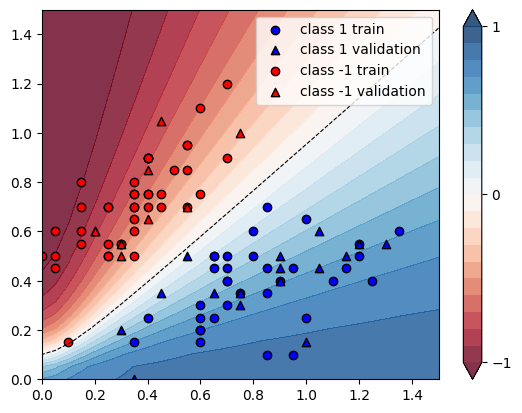

In [27]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = vqc(W, b, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()